In [1]:
from google.colab import files
uploaded = files.upload()

Saving potato.zip to potato.zip


In [2]:
import zipfile
with zipfile.ZipFile('potato.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/potato')

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
import os
print(os.listdir('/content'))
print(os.listdir('/content/potato'))
print(os.listdir('/content/potato/PlantVillage'))

['.config', 'drive', 'potato.zip', 'potato', 'sample_data']
['PlantVillage']
['Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight']


In [7]:
dataset_path = "/content/potato/PlantVillage"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


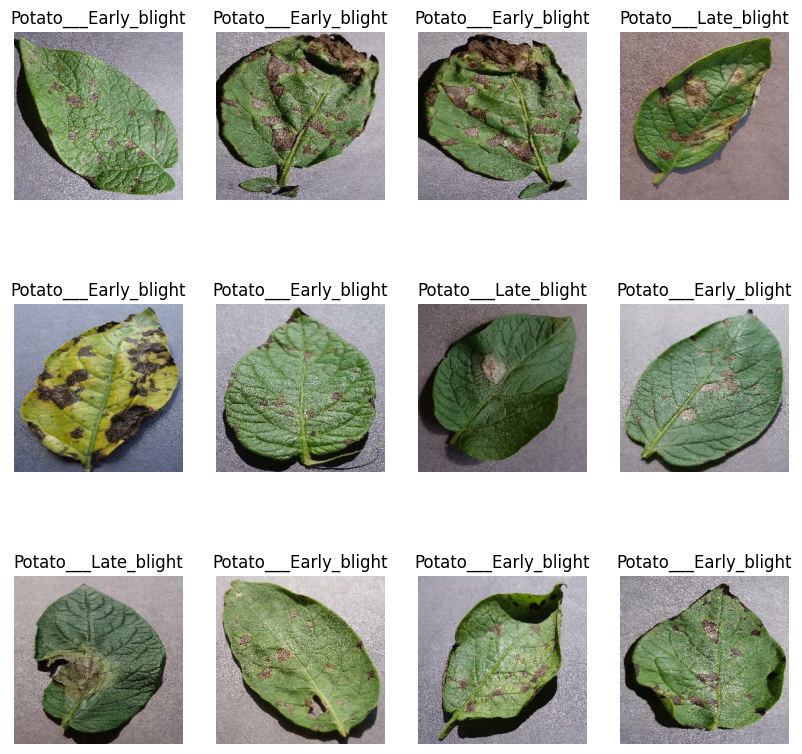

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

68

In [12]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [13]:
train_ds = dataset.take(54)
len(train_ds)

54

In [14]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
IMAGE_SIZE = 224
resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [25]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 222, 222, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 111, 111, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 109, 109, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 54, 54, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 52, 52, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 26, 26, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 24, 24, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 12, 12, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 10, 10, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 5, 5, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 3, 3, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 1, 1, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,459 (669.76 KB)

 Trainable params: 171,459 (669.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 441ms/step - accuracy: 0.5200 - loss: 0.9373 - val_accuracy: 0.5938 - val_loss: 0.7711
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 355ms/step - accuracy: 0.6309 - loss: 0.7652 - val_accuracy: 0.5573 - val_loss: 0.7921
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.7709 - loss: 0.5414 - val_accuracy: 0.8542 - val_loss: 0.3936
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.8337 - loss: 0.3959 - val_accuracy: 0.9010 - val_loss: 0.2690
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.8848 - loss: 0.3051 - val_accuracy: 0.9323 - val_loss: 0.1862
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - accuracy: 0.9213 - loss: 0.1802 - val_accuracy: 0.8958 - val_loss: 0.2825
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 356ms/step - accuracy: 0.9264 - loss: 0.1762 - val_accuracy: 0.8333 - val_loss: 0.4026
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 402ms/step - accuracy: 0.9331 - loss: 0.1635 - val_accu

In [32]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9747 - loss: 0.1011


In [33]:
scores

[0.07431095093488693, 0.98046875]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:
type(history.history['loss'])

list

In [38]:
history.history['loss'][:5]

[0.8847745060920715,
 0.7182278633117676,
 0.48822590708732605,
 0.38945692777633667,
 0.251869797706604]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [41]:
print(f"Training accuracy (acc) length: {len(acc)}")
print(f"Validation accuracy (val_acc) length: {len(val_acc)}")
print(f"Training loss (loss) length: {len(loss)}")
print(f"Validation loss (val_loss) length: {len(val_loss)}")

Training accuracy (acc) length: 50
Validation accuracy (val_acc) length: 50
Training loss (loss) length: 50
Validation loss (val_loss) length: 50


In [42]:
EPOCHS = len(acc)
EPOCHS

50

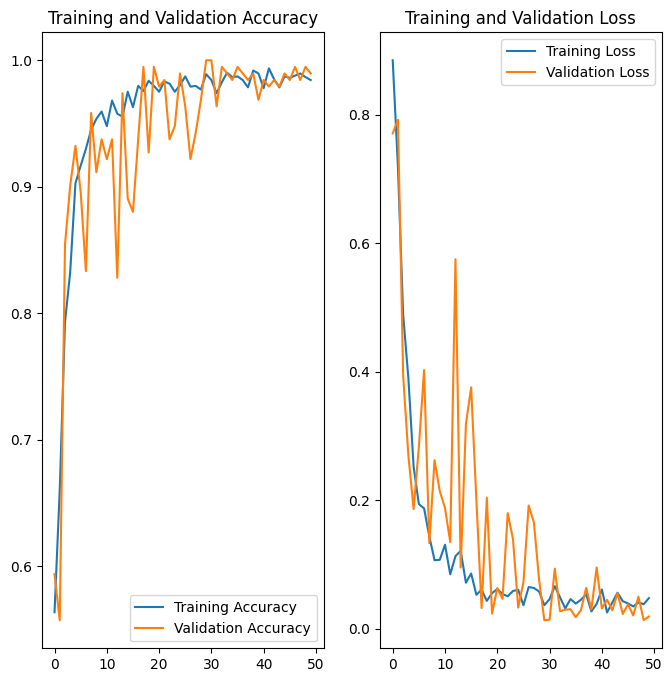

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')  # Use len(acc) here
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')  # Use len(val_acc) here
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
predicted label: Potato___Late_blight


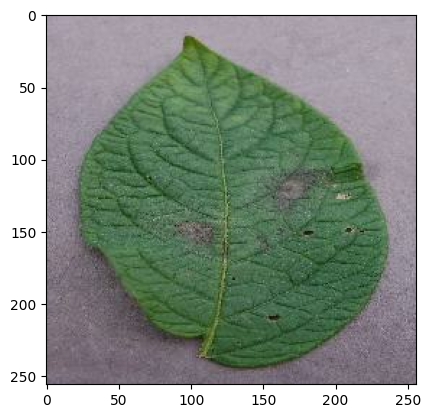

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


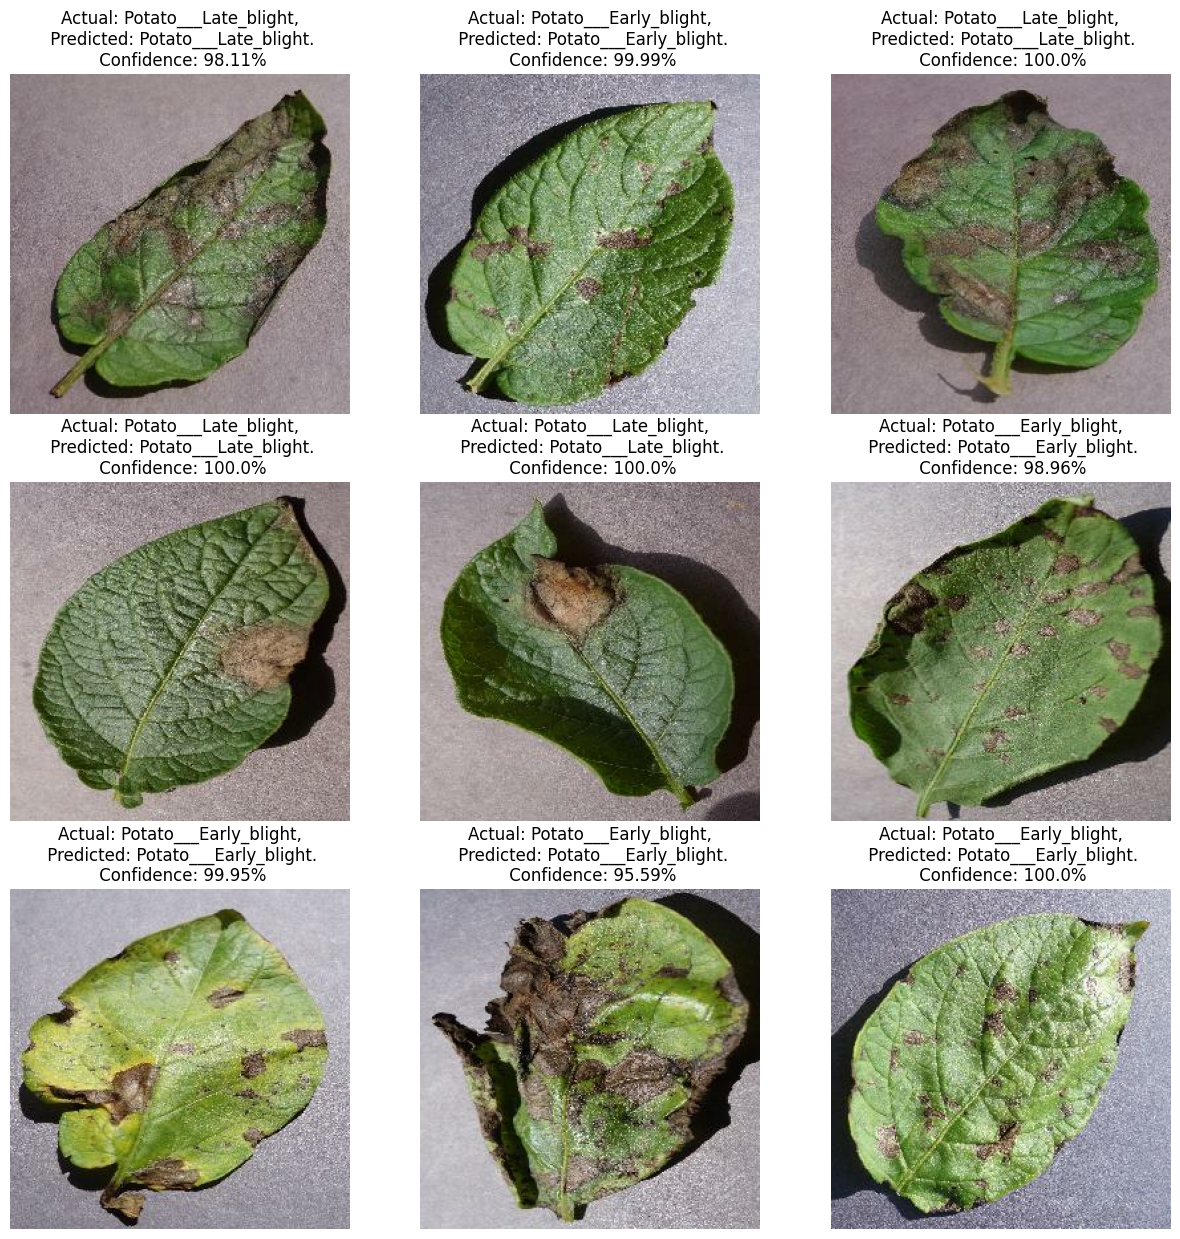

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [49]:
model.save("../potatoes.h5")